# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'comp411/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **comp411/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file comp411/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from comp411.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

0.062151037113730496
0.08377000853547376
0.10661713925794691
0.09254686329338024
0.08890793697941196
0.06405958698015018
0.12773565781180654
0.19340815611068707
0.06876888433773969
0.090934283536458
0.08405143831510178
0.09086755565872552
0.09997246733591798
0.061978776021025056
0.1291585828138934
0.08235552621609431
0.07202687157847866
0.0773019969520524
0.07884102160493463
0.05695184935209598
0.06644341294356508
0.10705556521842523
0.0790949438427455
0.09330875415385227
0.050582207530226
0.08692870064502016
0.044871303323433025
0.14663719858773822
0.16305576179546946
0.12868775493084064
0.07909391376974942
0.09542297299653582
0.07511216585658606
0.06636034492177695
0.0739981540233264
0.09414599187658275
0.26024381672546937
0.10743447238808868
0.09905167679707326
0.060840901891037656
0.10999844240035458
0.13623905669275282
0.07051202695507573
0.07702673308174571
0.1066534723385845
0.16815934600502594
0.0857111915805658
0.05869630310977154
0.07701371601380762
0.09567841265476369
0.0951

**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *we only apply the softmax on a dataset of 10 classes and randomly initialized weights. the probability of true class is equally likely = 1 / 10 = 0.1 and we are caculating the loss by taking -log(probabilty of true class) = -log(0.1)* 



In [19]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from comp411.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.943919 analytic: -0.943919, relative error: 3.519657e-08
numerical: -0.687300 analytic: -0.687300, relative error: 3.103912e-08
numerical: 1.187236 analytic: 1.187236, relative error: 2.165065e-08
numerical: -4.678429 analytic: -4.678429, relative error: 5.339003e-09
numerical: 1.263522 analytic: 1.263522, relative error: 4.010846e-09
numerical: 1.187236 analytic: 1.187236, relative error: 2.165065e-08
numerical: 2.227392 analytic: 2.227392, relative error: 2.284258e-08
numerical: 0.016010 analytic: 0.016010, relative error: 3.231200e-06
numerical: 3.379301 analytic: 3.379301, relative error: 3.001286e-09
numerical: -0.426644 analytic: -0.426644, relative error: 3.907504e-08
numerical: -2.228555 analytic: -2.228555, relative error: 8.616062e-09
numerical: 0.413787 analytic: 0.413787, relative error: 7.305354e-08
numerical: -1.830245 analytic: -1.830244, relative error: 3.366222e-09
numerical: 0.744633 analytic: 0.744633, relative error: 8.197844e-09
numerical: -4.503491 a

In [20]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.350384e+00 computed in 0.121560s
vectorized loss: 2.350384e+00 computed in 0.003058s
Loss difference: 0.000000
Gradient difference: 0.000000


In [21]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from comp411.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 15e-7]
regularization_strengths = [2.5e4, 5e4, 5e2]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


grid_search = [ (lr,rg) for lr in learning_rates for rg in regularization_strengths ]

for lr, rg in grid_search:
    # Create a new SVM instance
    softmax = Softmax()
    # Train the model with current parameters
    train_loss = softmax.train(X_train, y_train, learning_rate=lr, reg=rg,
                      num_iters=1500, verbose=False)
    # Predict values for training set
    y_train_pred = softmax.predict(X_train)
    # Calculate accuracy
    train_accuracy = np.mean(y_train_pred == y_train)
    # Predict values for validation set
    y_val_pred = softmax.predict(X_val)
    # Calculate accuracy
    val_accuracy = np.mean(y_val_pred == y_val)
    # Save results
    results[(lr,rg)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_softmax = softmax


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 5.000000e+02 train accuracy: 0.257102 val accuracy: 0.275000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.329245 val accuracy: 0.341000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.305918 val accuracy: 0.328000
lr 5.000000e-07 reg 5.000000e+02 train accuracy: 0.362551 val accuracy: 0.366000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.332245 val accuracy: 0.351000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.310449 val accuracy: 0.323000
lr 1.500000e-06 reg 5.000000e+02 train accuracy: 0.404857 val accuracy: 0.406000
lr 1.500000e-06 reg 2.500000e+04 train accuracy: 0.297224 val accuracy: 0.312000
lr 1.500000e-06 reg 5.000000e+04 train accuracy: 0.302163 val accuracy: 0.292000
best validation accuracy achieved during cross-validation: 0.406000


In [22]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.386000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ *True*


$\color{blue}{\textit Your Explanation:}$ *In the SVM hinge loss, we have ${L_{i} = max(0, S_{j} - S_{y_{i}}}$ + 1). if we add a new training data point with score less than the true score, this still will give the same previous loss. But in softmax, we are exponentiate and normalize all scores, so adding new training point changes the loss*



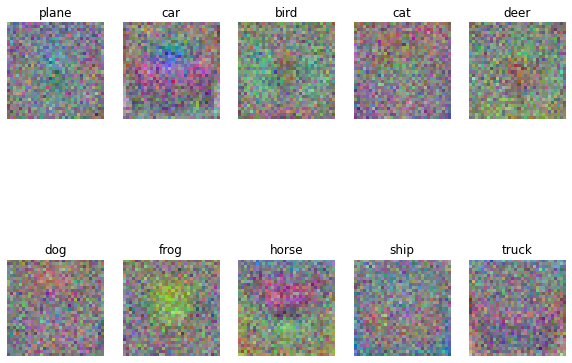

In [23]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])